<a href="https://colab.research.google.com/github/atharv-arya/3D-Brain-Tumor-Segmentation/blob/main/3D_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install segmentation_models_pytorch_3d
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.8/626.8 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### ONLY RUN ONCE
# # Step 2: Extract the ZIP into the proper folder
# import zipfile
# import os

# zip_path = "/content/drive/MyDrive/CSCI566/data/dl_data_final.zip"
# extract_path = "/content/drive/MyDrive/DL 3D Resnet Findings"

# # Create the extract directory if it doesn't exist
# os.makedirs(extract_path, exist_ok=True)

# # Unzip
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# print("✅ Extracted to:", extract_path)


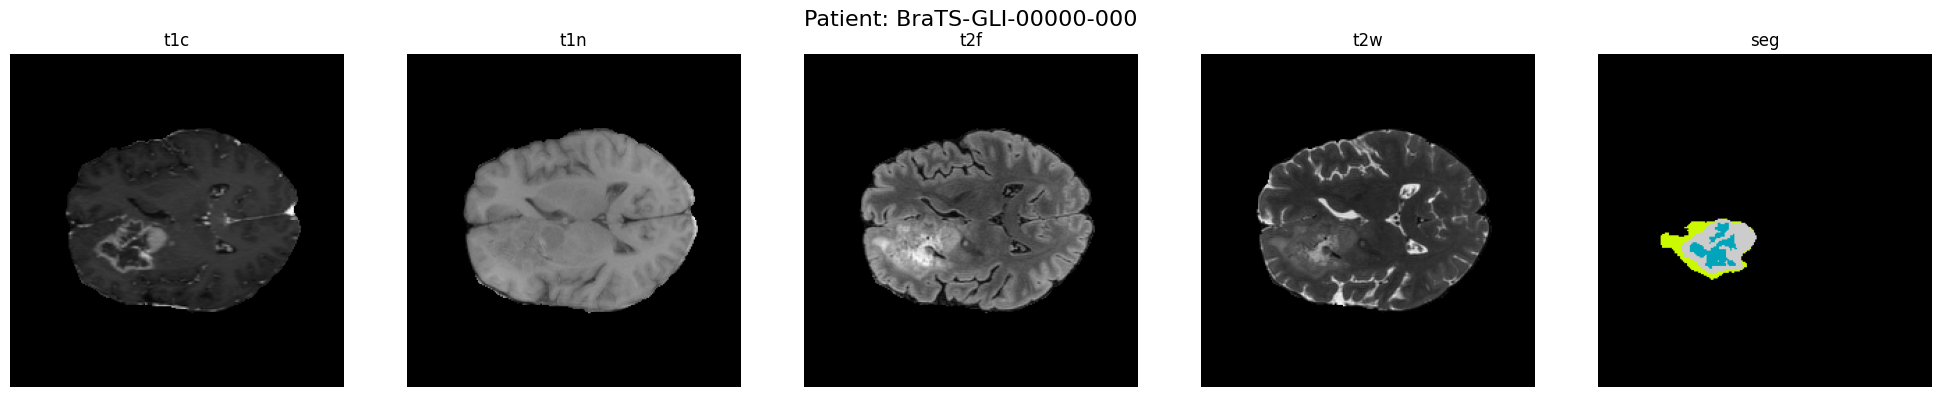

In [3]:
# Step 3: Analyze one patient from train/
import nibabel as nib
import matplotlib.pyplot as plt
import os

extract_path = "/content/drive/MyDrive/DL 3D Resnet Findings"

# Path to the extracted patient folder
patient_id = "BraTS-GLI-00000-000"
patient_path = os.path.join(extract_path, "dl_data_final", "train", patient_id)

# Modalities
modalities = ["t1c", "t1n", "t2f", "t2w", "seg"]
images = {}

# Load the modalities
for mod in modalities:
    file_path = os.path.join(patient_path, f"{patient_id}-{mod}.nii.gz")
    try:
        img = nib.load(file_path)
        images[mod] = img.get_fdata()
    except Exception as e:
        print(f"❌ Could not load {mod}: {e}")
        images[mod] = None

# Visualize axial mid-slice
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, mod in enumerate(modalities):
    ax = axes[i]
    img = images[mod]
    if img is not None:
        mid = img.shape[2] // 2
        cmap = "nipy_spectral" if mod == "seg" else "gray"
        ax.imshow(img[:, :, mid], cmap=cmap)
        ax.set_title(mod)
    else:
        ax.text(0.5, 0.5, "Load error", ha="center", va="center")
    ax.axis("off")

plt.suptitle(f"Patient: {patient_id}", fontsize=16)
plt.tight_layout()
plt.show()


# Validating Training Set
##(Making sure the data is clean and we do not have any bad inputs, ex NaN, Infs or Zeros values)



In [4]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import os

train_dir = "/content/drive/MyDrive/DL 3D Resnet Findings/dl_data_final/train"
modalities = ["t1c", "t1n", "t2f", "t2w", "seg"]

###0 Function to validate one patient
def validate_patient(patient_id):
    patient_path = os.path.join(train_dir, patient_id)
    shapes = []
    issues = []

    for mod in modalities:
        path = os.path.join(patient_path, f"{patient_id}-{mod}.nii.gz")
        if not os.path.exists(path):
            issues.append(f"{mod} missing")
            continue

        try:
            img = nib.load(path)
            data = img.get_fdata()

            # Shape check
            shapes.append(data.shape)

            # Data checks
            if np.isnan(data).any():
                issues.append(f"{mod} has NaNs")
            if np.isinf(data).any():
                issues.append(f"{mod} has Infs")
            if np.all(data == 0):
                issues.append(f"{mod} is all zeros")

            # Seg label check
            if mod == "seg":
                unique_vals = np.unique(data)
                if not np.all(np.isin(unique_vals, [0, 1, 2, 3])):  # Adjust if needed
                    issues.append(f"seg has invalid labels: {unique_vals}")

        except Exception as e:
            issues.append(f"Error loading {mod}: {e}")

    # Check shape consistency
    if len(set(shapes)) > 1:
        issues.append(f"Shape mismatch: {shapes}")

    return issues

In [ ]:
# Running takes about 1hr 30 mins. Validates if all patient scan details are fine. NO NEED TO RUN AGAIN
# Validating all patients
# patients = sorted([
#     f for f in os.listdir(train_dir)
#     if not f.startswith('.') and os.path.isdir(os.path.join(train_dir, f))
# ])

# print("🔍 Validating training data...\n")
# for pid in patients:
#     issues = validate_patient(pid)
#     if issues:
#         print(f"⚠️ {pid} has issues:")
#         for issue in issues:
#             print("   -", issue)
#     else:
#         print(f"✅ {pid} is clean")


# Pytorch Dataset and DataLoader


In [ ]:
### CODE FOR DELETING ALL .NPY FILES

# import os

# # Change this to your Drive path (e.g. inside MyDrive)
# root_dir = '/content/drive/MyDrive'

# # Loop through all files and delete .npy
# deleted = 0
# for dirpath, _, filenames in os.walk(root_dir):
#     for file in filenames:
#         if file.endswith('.npy'):
#             file_path = os.path.join(dirpath, file)
#             os.remove(file_path)
#             print(f"Deleted: {file_path}")
#             deleted += 1

# print(f"\n✅ Deleted {deleted} .npy files.")


In [4]:
import os
import torch
from torch.utils.data import Dataset
import nibabel as nib
import numpy as np

class BraTSDataset(Dataset):
    def __init__(self, root_dir, patient_ids, modalities=["t1c", "t1n", "t2f", "t2w"], crop_size=(128, 128, 128), transform=None):
        self.root_dir = root_dir
        self.patient_ids = patient_ids
        self.modalities = modalities
        self.crop_size = crop_size
        self.transform = transform

    def normalize(self, vol):
        mean = np.mean(vol)
        std = np.std(vol)
        return (vol - mean) / std if std != 0 else vol

    def center_crop(self, vol, crop_size):
        D, H, W = vol.shape
        cd, ch, cw = crop_size
        d_start = max((D - cd) // 2, 0)
        h_start = max((H - ch) // 2, 0)
        w_start = max((W - cw) // 2, 0)
        return vol[d_start:d_start+cd, h_start:h_start+ch, w_start:w_start+cw]

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        pid = self.patient_ids[idx]
        patient_path = os.path.join(self.root_dir, pid)

        # Load and normalize each modality
        channels = []
        for mod in self.modalities:
            file_path = os.path.join(patient_path, f"{pid}-{mod}.nii.gz")
            img = nib.load(file_path).get_fdata()
            img = self.normalize(img)
            img = self.center_crop(img, self.crop_size)  # ✅ crop each modality
            channels.append(img)

        # Stack into [4, D, H, W]
        image = np.stack(channels, axis=0).astype(np.float32)

        # Load and crop segmentation mask [D, H, W]
        mask_path = os.path.join(patient_path, f"{pid}-seg.nii.gz")
        mask = nib.load(mask_path).get_fdata().astype(np.uint8)
        mask = self.center_crop(mask, self.crop_size)

        # Convert to tensors
        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)

        return image, mask

In [5]:
from torch.utils.data import DataLoader, random_split

# Path to raw .nii.gz dataset
train_path = "/content/drive/MyDrive/DL 3D Resnet Findings/dl_data_final/train"

# Get patient list
all_patients = sorted([
    f for f in os.listdir(train_path)
    if not f.startswith('.') and os.path.isdir(os.path.join(train_path, f))
])


# 80-20 train-val split
total_patients = len(all_patients)
split_index = int(0.8 * total_patients)

train_patients = all_patients[:split_index]
val_patients = all_patients[split_index:]

# Instantiate datasets
train_dataset = BraTSDataset(train_path, train_patients)
val_dataset = BraTSDataset(train_path, val_patients)

# DataLoaders (GPU-ready)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True, prefetch_factor=2)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)


# 3D ResNet Model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm3d(out_channels)
            )

    def forward(self, x):
        identity = self.downsample(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(out + identity)

class ResNet3DSeg(nn.Module):
    def __init__(self, in_channels=4, num_classes=4):
        super(ResNet3DSeg, self).__init__()
        self.enc1 = BasicBlock3D(in_channels, 32)
        self.enc2 = BasicBlock3D(32, 64, stride=2)
        self.enc3 = BasicBlock3D(64, 128, stride=2)
        self.enc4 = BasicBlock3D(128, 256, stride=2)

        self.up3 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        self.dec3 = BasicBlock3D(128, 128)
        self.up2 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.dec2 = BasicBlock3D(64, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.dec1 = BasicBlock3D(32, 32)

        self.final = nn.Conv3d(32, num_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x4 = self.enc4(x3)

        x = self.up3(x4)
        x = self.dec3(x)
        x = self.up2(x)
        x = self.dec2(x)
        x = self.up1(x)
        x = self.dec1(x)

        return self.final(x)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet3DSeg(in_channels=4, num_classes=4).to(device)
model = torch.compile(model)

##1. Dice Loss Implementation

In [8]:
import torch.nn as nn
import torch.nn.functional as F

def center_crop_to_match(pred, target):
    _, _, Dp, Hp, Wp = pred.shape
    Dt, Ht, Wt = target.shape[1:]

    dz = (Dp - Dt) // 2
    dy = (Hp - Ht) // 2
    dx = (Wp - Wt) // 2

    return pred[:, :, dz:dz+Dt, dy:dy+Ht, dx:dx+Wt]


from segmentation_models_pytorch_3d.losses import DiceLoss, FocalLoss

# DiceLoss supports from_logits, FocalLoss does not
dice_loss = DiceLoss(mode='multiclass', from_logits=True)
focal_loss = FocalLoss(mode='multiclass')

def combined_loss(output, target):
    """
    output: logits from the model (B, C, D, H, W)
    target: one-hot encoded target (B, C, D, H, W)
    """
    return dice_loss(output, target) + focal_loss(output, target)



## 2. Training & Validation Loops

In [9]:
from tqdm import tqdm
from torch.amp import autocast, GradScaler
scaler = GradScaler(device='cuda')

from torchmetrics.classification import MulticlassAccuracy
from torchmetrics import MeanMetric
import segmentation_models_pytorch_3d as smp_3d

def train_one_epoch(model, loader, optimizer, criterion, device, num_classes=4, epoch_idx=1, total_epochs=50):
    model.train()

    loss_record = MeanMetric().to(device)
    iou_record = MeanMetric().to(device)
    acc_record = MulticlassAccuracy(num_classes=num_classes, average='macro').to(device)

    loader_len = len(loader)

    with tqdm(total=loader_len, ncols=120) as tq:
        tq.set_description(f"Train :: Epoch {epoch_idx}/{total_epochs}")
        for X, y in loader:
            tq.update(1)
            X, y = X.to(device), y.to(device)
            y = y.long()

            optimizer.zero_grad()

            with autocast(device_type="cuda"):
              outputs = model(X)
              outputs = center_crop_to_match(outputs, y)
              loss = criterion(outputs, y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            with torch.no_grad():
                preds = torch.argmax(outputs, dim=1)  # [B, D, H, W]

                tp, fp, fn, tn = smp_3d.metrics.get_stats(preds, y, mode='multiclass', num_classes=num_classes)
                iou_macro = smp_3d.metrics.iou_score(tp, fp, fn, tn, reduction='macro')

                acc_record.update(preds, y)  # both already on GPU
                loss_record.update(loss.detach().to(device), weight=X.shape[0])
                iou_record.update(iou_macro.to(device), weight=X.shape[0])

            tq.set_postfix_str(f"Loss: {loss_record.compute():.4f} | IoU: {iou_record.compute():.4f} | Acc: {acc_record.compute():.4f}")


    return loss_record.compute(), iou_record.compute(), acc_record.compute()


def validate(model, loader, criterion, device, num_classes=4):
    model.eval()

    loss_record = MeanMetric().to(device)
    iou_record = MeanMetric().to(device)
    acc_record = MulticlassAccuracy(num_classes=num_classes, average='macro').to(device)

    with torch.no_grad():
        for X, y in tqdm(loader, desc="📏 Validating", leave=False):
            X, y = X.to(device), y.to(device)
            y = y.long()

            outputs = model(X)
            outputs = center_crop_to_match(outputs, y)
            loss = criterion(outputs, y)

            preds = torch.argmax(outputs, dim=1)
            y_true = y

            tp, fp, fn, tn = smp_3d.metrics.get_stats(preds, y_true, mode='multiclass', num_classes=num_classes)
            iou_macro = smp_3d.metrics.iou_score(tp, fp, fn, tn, reduction='macro')

            acc_record.update(preds, y_true)
            loss_record.update(loss.detach().to(device), weight=X.shape[0])
            iou_record.update(iou_macro.to(device), weight=X.shape[0])

    return loss_record.compute(), iou_record.compute(), acc_record.compute()



## 3. Train the Model

In [20]:
import os
from torch.optim import Adam

# Paths for checkpointing
checkpoint_path = "/content/drive/MyDrive/DL 3D Resnet Findings/checkpoint_latest.pth"
best_model_path = "/content/drive/MyDrive/DL 3D Resnet Findings/best_model.pth"

# Re-initialize model, optimizer, and AMP scaler
model = ResNet3DSeg(in_channels=4, num_classes=4).to(device)
criterion = combined_loss
optimizer = Adam(model.parameters(), lr=2e-4)
scaler = GradScaler(device='cuda')

# Resume from checkpoint if available
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scaler.load_state_dict(checkpoint['scaler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"🔁 Resuming training from epoch {start_epoch}")
else:
    #shows model architecture on first run
    start_epoch = 0
    print("🆕 Starting training from scratch")
    print(model)


🔁 Resuming training from epoch 19


In [ ]:
import pickle

EPOCHS = 100
best_val_loss = float('inf')
patience = 10
early_stop_counter = 0

# Initialize logs
train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_accs, val_accs = [], []

for epoch in range(start_epoch, EPOCHS):
    print(f"\n => Epoch {epoch+1}/{EPOCHS}")

    # Training and Validation
    train_loss, train_iou, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, epoch_idx=epoch+1, total_epochs=EPOCHS)
    val_loss, val_iou, val_acc = validate(model, val_loader, criterion, device)

    # Print metrics
    print(f" Train Loss: {train_loss:.4f} |  IoU: {train_iou:.4f} |  Accuracy: {train_acc:.4f}")
    print(f" Val   Loss: {val_loss:.4f} |  IoU: {val_iou:.4f} |  Accuracy: {val_acc:.4f}")

    # Store metrics
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    train_ious.append(train_iou.item())
    val_ious.append(val_iou.item())
    train_accs.append(train_acc.item())
    val_accs.append(val_acc.item())

    # Save latest checkpoint
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict()
    }
    torch.save(checkpoint, checkpoint_path)

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(" Best model updated!")
    else:
        early_stop_counter += 1
        print(f" No improvement. Early stop counter: {early_stop_counter}/{patience}")
        if early_stop_counter >= patience:
            print(" Early stopping triggered!")
            break

# Save training logs
logs = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_ious": train_ious,
    "val_ious": val_ious,
    "train_accs": train_accs,
    "val_accs": val_accs
}

with open("/content/drive/MyDrive/DL 3D Resnet Findings/train_logs.pkl", "wb") as f:
    pickle.dump(logs, f)

print(" Training logs saved to train_logs.pkl")


In [14]:
## Saving the model

torch.save(model.state_dict(), "/content/drive/MyDrive/DL 3D Resnet Findings/3dresnet_model.pth")
print("✅ Model saved!")

✅ Model saved!


In [10]:
model = ResNet3DSeg(in_channels=4, num_classes=4).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/DL 3D Resnet Findings/best_model.pth"))
model.eval()
print("✅ Model loaded and ready for inference!")

## In future if ever need to use it again, just do the following:
# model = ResNet3DSeg(in_channels=4, num_classes=4).to(device)
# model.load_state_dict(torch.load("/content/drive/MyDrive/DL 3D Resnet Findings/3dresnet_model.pth"))
# model.eval()
# with torch.no_grad():
#     for X, y in test_loader:  # or any new data
#         X = X.to(device)
#         output = model(X)
#         prediction = torch.argmax(output, dim=1)  # [B, D, H, W]


✅ Model loaded and ready for inference!


### Training Visualizations (Loss over Epochs AND IoU over Epochs)

In [11]:
### Getting the losses from train_logs.pkl file in the drive
import pickle

with open("/content/drive/MyDrive/DL 3D Resnet Findings/train_logs.pkl", "rb") as f:
    logs = pickle.load(f)

# Extract data
train_losses = logs["train_losses"]
val_losses = logs["val_losses"]
train_ious = logs["train_ious"]
val_ious = logs["val_ious"]


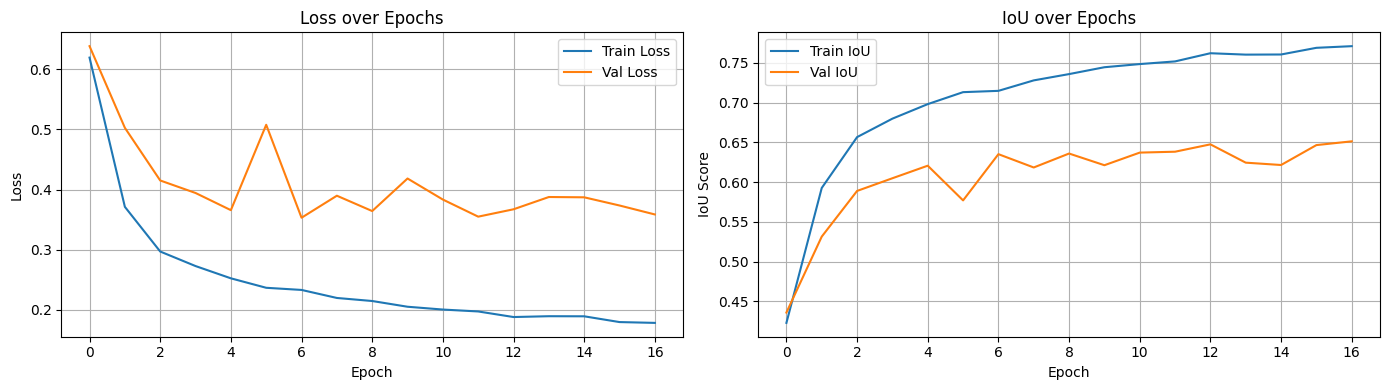

In [12]:
import matplotlib.pyplot as plt

epochs_range = range(len(train_losses))

plt.figure(figsize=(14, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot IoU
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_ious, label="Train IoU")
plt.plot(epochs_range, val_ious, label="Val IoU")
plt.title("IoU over Epochs")
plt.xlabel("Epoch")
plt.ylabel("IoU Score")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Code for saving the above Loss and IOU grpahs in the drive

In [25]:
# import os
# import matplotlib.pyplot as plt

# # Define your save path
# save_path = "/content/drive/MyDrive/CSCI566/3D Resnet"
# os.makedirs(save_path, exist_ok=True)

# # Save Loss Curve
# plt.figure(figsize=(7, 4))
# plt.plot(epochs_range, train_losses, label="Train Loss")
# plt.plot(epochs_range, val_losses, label="Val Loss")
# plt.title("Loss over Epochs")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.savefig(os.path.join(save_path, "updated loss curve (final).png"))
# plt.close()

# # Save IoU Curve
# plt.figure(figsize=(7, 4))
# plt.plot(epochs_range, train_ious, label="Train IoU")
# plt.plot(epochs_range, val_ious, label="Val IoU")
# plt.title("IoU over Epochs")
# plt.xlabel("Epoch")
# plt.ylabel("IoU Score")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.savefig(os.path.join(save_path, "updated iou curve (final).png"))
# plt.close()


### Predicted Mask Vs True Mask (for a random patient)

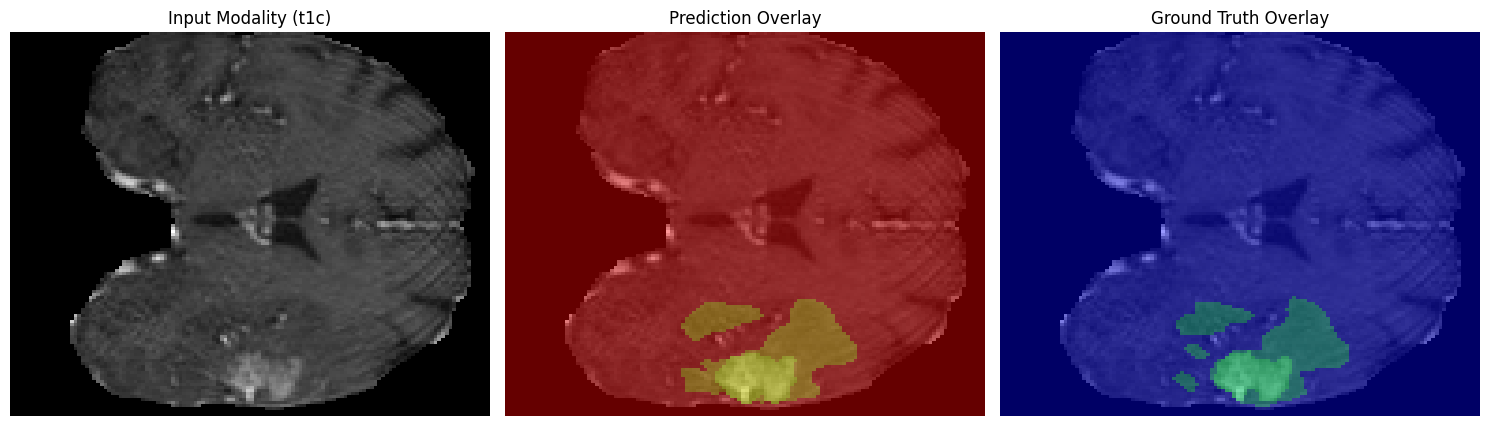

In [27]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

model.eval()
sample_idx = random.randint(0, len(val_dataset) - 1)
X, y_true = val_dataset[sample_idx]
X = X.unsqueeze(0).to(device)
y_true = y_true.numpy()

with torch.no_grad():
    output = model(X)
    pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()

# Use axial slice
mid_slice = 64

fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # slightly taller

# Raw T1c image
axs[0].imshow(X[0, 0, :, mid_slice, :].cpu(), cmap="gray",
              interpolation="none", aspect=0.8)
axs[0].set_title("Input Modality (t1c)")
axs[0].axis("off")

# Prediction overlay
axs[1].imshow(X[0, 0, :, mid_slice, :].cpu(), cmap="gray",
              interpolation="none", aspect=0.8)
axs[1].imshow(pred[:, mid_slice, :], cmap="autumn", alpha=0.4,
              interpolation="none", aspect=0.8)
axs[1].set_title("Prediction Overlay")
axs[1].axis("off")

# Ground truth overlay
axs[2].imshow(X[0, 0, :, mid_slice, :].cpu(), cmap="gray",
              interpolation="none", aspect=0.8)
axs[2].imshow(y_true[:, mid_slice, :], cmap="winter", alpha=0.4,
              interpolation="none", aspect=0.8)
axs[2].set_title("Ground Truth Overlay")
axs[2].axis("off")

plt.tight_layout()
plt.show()


# Evaluation on the Validation Set

### Inference on Validation Set

In [ ]:
import torch
from tqdm import tqdm

# Ensure model is in eval mode
model.eval()

# Containers to store inference results
val_preds = []
val_targets = []
val_inputs = []

with torch.no_grad():
    for X, y in tqdm(val_loader, desc="Running Inference on Validation Set"):
        X, y = X.to(device), y.to(device)
        y = y.long()  # Ensure ground truth is of Long type

        logits = model(X)
        logits = center_crop_to_match(logits, y)  # Match shape
        preds = torch.argmax(logits, dim=1)       # Convert to class labels

        val_preds.append(preds.cpu())
        val_targets.append(y.cpu())
        val_inputs.append(X.cpu())  # All modalities [B, 4, D, H, W]

# Concatenate batch-wise outputs
val_preds = torch.cat(val_preds, dim=0)      # [N, D, H, W]
val_targets = torch.cat(val_targets, dim=0)  # [N, D, H, W]
val_inputs = torch.cat(val_inputs, dim=0)    # [N, 4, D, H, W]

print("Inference completed on validation set!")
print(f"Pred shape    : {val_preds.shape}")
print(f"Target shape  : {val_targets.shape}")
print(f"Input shape   : {val_inputs.shape}")


Running Inference on Validation Set: 100%|██████████| 202/202 [01:25<00:00,  2.35it/s]


Inference completed on validation set!
Pred shape    : torch.Size([202, 128, 128, 128])
Target shape  : torch.Size([202, 128, 128, 128])
Input shape   : torch.Size([202, 4, 128, 128, 128])


### Computing metrics (Dice,IoU,Precison,Recall,F1) for Val set


In [ ]:
def compute_metrics_onehot(preds, targets, num_classes=4, smooth=1e-6):
    """
    preds and targets: [N, D, H, W] with class indices
    Returns: Dict of metrics per class
    """
    preds_onehot = F.one_hot(preds, num_classes).permute(0, 4, 1, 2, 3).float()  # [N, C, D, H, W]
    targets_onehot = F.one_hot(targets, num_classes).permute(0, 4, 1, 2, 3).float()

    metrics = {'IoU': [], 'Precision': [], 'Recall': [], 'F1': [], 'Dice': []}

    for cls in range(num_classes):
        pred_cls = preds_onehot[:, cls]
        true_cls = targets_onehot[:, cls]

        intersection = (pred_cls * true_cls).sum()
        union = pred_cls.sum() + true_cls.sum()
        precision = intersection / (pred_cls.sum() + smooth)
        recall = intersection / (true_cls.sum() + smooth)
        f1 = 2 * (precision * recall) / (precision + recall + smooth)
        iou = intersection / (union - intersection + smooth)
        dice = (2 * intersection + smooth) / (union + smooth)

        metrics['IoU'].append(iou.item())
        metrics['Precision'].append(precision.item())
        metrics['Recall'].append(recall.item())
        metrics['F1'].append(f1.item())
        metrics['Dice'].append(dice.item())

    return metrics


metrics = compute_metrics_onehot(val_preds, val_targets, num_classes=4)

for i, cls_name in enumerate(['Background', 'Edema', 'Non-enhancing', 'Enhancing']):
    print(f"\n📊 Class {i} – {cls_name}")
    print(f"IoU        : {metrics['IoU'][i]:.4f}")
    print(f"Precision  : {metrics['Precision'][i]:.4f}")
    print(f"Recall     : {metrics['Recall'][i]:.4f}")
    print(f"F1 Score   : {metrics['F1'][i]:.4f}")
    print(f"Dice Score : {metrics['Dice'][i]:.4f}")

# Averages
print("\n📈 Average Scores across all classes:")
print(f"Mean IoU        : {sum(metrics['IoU']) / 4:.4f}")
print(f"Mean Precision  : {sum(metrics['Precision']) / 4:.4f}")
print(f"Mean Recall     : {sum(metrics['Recall']) / 4:.4f}")
print(f"Mean F1 Score   : {sum(metrics['F1']) / 4:.4f}")
print(f"Mean Dice Score : {sum(metrics['Dice']) / 4:.4f}")



📊 Class 0 – Background
IoU        : 0.9903
Precision  : 0.9939
Recall     : 0.9963
F1 Score   : 0.9951
Dice Score : 0.9951

📊 Class 1 – Edema
IoU        : 0.3074
Precision  : 0.8903
Recall     : 0.3195
F1 Score   : 0.4702
Dice Score : 0.4702

📊 Class 2 – Non-enhancing
IoU        : 0.6115
Precision  : 0.7064
Recall     : 0.8198
F1 Score   : 0.7589
Dice Score : 0.7589

📊 Class 3 – Enhancing
IoU        : 0.7374
Precision  : 0.8248
Recall     : 0.8744
F1 Score   : 0.8489
Dice Score : 0.8489

📈 Average Scores across all classes:
Mean IoU        : 0.6616
Mean Precision  : 0.8539
Mean Recall     : 0.7525
Mean F1 Score   : 0.7683
Mean Dice Score : 0.7683


### Loss (Train Vs Val)

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
loss_path = "/content/drive/MyDrive/DL 3D Resnet Findings/loss_curve.png"
plt.savefig(loss_path)
plt.close()
print(f"✅ Loss curve saved to {loss_path}")


✅ Loss curve saved to /content/drive/MyDrive/DL 3D Resnet Findings/loss_curve.png


### IoU (Train Vs Val)

In [ ]:
# Plot IoU
plt.figure(figsize=(8, 5))
plt.plot(train_ious, label="Train IoU")
plt.plot(val_ious, label="Val IoU")
plt.title("IoU over Epochs")
plt.xlabel("Epoch")
plt.ylabel("IoU Score")
plt.legend()
plt.grid(True)
iou_path = "/content/drive/MyDrive/DL 3D Resnet Findings/iou_curve.png"
plt.savefig(iou_path)
plt.close()
print(f"✅ IoU curve saved to {iou_path}")


✅ IoU curve saved to /content/drive/MyDrive/DL 3D Resnet Findings/iou_curve.png


### Accuracy Curve (Train Vs Val)

In [ ]:
# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

acc_path = "/content/drive/MyDrive/DL 3D Resnet Findings/accuracy_curve.png"
plt.savefig(acc_path)
plt.close()

print(f"✅ Accuracy curve saved to {acc_path}")


✅ Accuracy curve saved to /content/drive/MyDrive/DL 3D Resnet Findings/accuracy_curve.png


In [ ]:
from tqdm import tqdm

X_list, y_list, pred_list = [], [], []

model.eval()
with torch.no_grad():
    for X, y in tqdm(val_loader, desc="🔍 Re-inference on Validation Set"):
        X = X.to(device)
        logits = model(X)
        preds = torch.argmax(logits, dim=1)

        X_list.append(X.cpu())
        y_list.append(y.cpu())
        pred_list.append(preds.cpu())

X_val_tensor = torch.cat(X_list, dim=0)     # shape: [N, 4, D, H, W]
y_val_tensor = torch.cat(y_list, dim=0)     # shape: [N, D, H, W]
preds_tensor = torch.cat(pred_list, dim=0)  # shape: [N, D, H, W]


🔍 Re-inference on Validation Set: 100%|██████████| 202/202 [01:27<00:00,  2.31it/s]


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

def visualize_patient_prediction(X_tensor, y_tensor, pred_tensor, indices, save_dir="/content/drive/MyDrive/DL 3D Resnet Findings/visualizations"):
    os.makedirs(save_dir, exist_ok=True)
    modality_names = ["FLAIR", "T1", "T1ce", "T2"]

    for idx in indices:
        out_path = os.path.join(save_dir, f"patient_{idx}_combined.png")
        if os.path.exists(out_path):
            print(f"⚠️ Skipping Patient {idx}: Output already exists.")
            continue

        X = X_tensor[idx].cpu().numpy()     # [4, D, H, W]
        gt = y_tensor[idx].cpu().numpy()    # [D, H, W]
        pred = pred_tensor[idx].cpu().numpy()  # [D, H, W]
        best_slice = gt.shape[0] // 2       # axial mid-slice

        # Zoom slice (center of detected tumor region)
        combined_mask = np.logical_or(gt > 0, pred > 0)
        coords = np.array(np.where(combined_mask))
        zoom_slice = (coords[0].min() + coords[0].max()) // 2 if coords.shape[1] > 0 else best_slice

        fig, axs = plt.subplots(3, 4, figsize=(18, 10))

        # Row 1: Modalities at best slice
        for i in range(4):
            axs[0, i].imshow(X[i, best_slice], cmap="gray")
            axs[0, i].set_title(f"{modality_names[i]} - Slice {best_slice}")
            axs[0, i].axis("off")

        # Row 2: GT and Prediction Overlays at best slice
        axs[1, 0].imshow(X[0, best_slice], cmap="gray")
        axs[1, 0].contour(gt[best_slice], colors='g', linewidths=1)
        axs[1, 0].contour(pred[best_slice], colors='r', linewidths=1)
        axs[1, 0].set_title("Overlay (True=Green, Pred=Red)")
        axs[1, 0].axis("off")

        axs[1, 1].imshow(gt[best_slice], cmap="jet")
        axs[1, 1].set_title("GT Mask")
        axs[1, 1].axis("off")

        axs[1, 2].imshow(pred[best_slice], cmap="jet")
        axs[1, 2].set_title("Pred Mask")
        axs[1, 2].axis("off")

        axs[1, 3].axis("off")  # Empty for layout symmetry

        # Row 3: Zoom View around tumor
        base = X[0, zoom_slice]
        axs[2, 0].imshow(base, cmap="gray")
        axs[2, 0].set_title(f"FLAIR - Slice {zoom_slice}")
        axs[2, 0].axis("off")

        axs[2, 1].imshow(base, cmap="gray")
        axs[2, 1].imshow(gt[zoom_slice], cmap="jet", alpha=0.4)
        axs[2, 1].set_title("True Overlay")
        axs[2, 1].axis("off")

        axs[2, 2].imshow(base, cmap="gray")
        axs[2, 2].imshow(pred[zoom_slice], cmap="jet", alpha=0.4)
        axs[2, 2].set_title("Pred Overlay")
        axs[2, 2].axis("off")

        axs[2, 3].axis("off")  # for layout balance

        plt.suptitle(f"Patient {idx} - Visualization Summary", fontsize=16)
        plt.tight_layout()
        plt.savefig(out_path)
        plt.close()

        print(f"✅ Saved: {out_path}")


In [ ]:
sample_indices = np.random.choice(len(X_val_tensor), 1, replace=False)
visualize_patient_prediction(X_val_tensor, y_val_tensor, preds_tensor, sample_indices)


✅ Saved: /content/drive/MyDrive/DL 3D Resnet Findings/visualizations/patient_156_combined.png


# Evaluate the Model on the Test Set

##  Setup Test Dataset & DataLoader

In [28]:
test_path = "/content/drive/MyDrive/DL 3D Resnet Findings/dl_data_final/test"

# Get list of test patients
test_patients = sorted([
    f for f in os.listdir(test_path)
    if not f.startswith('.') and os.path.isdir(os.path.join(test_path, f))
])

# Dataset & DataLoader
test_dataset = BraTSDataset(test_path, test_patients)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)


## Dice Score Function (Inference version)

In [29]:
def compute_dice_score(pred, target, num_classes=4, smooth=1e-5):
    pred = torch.argmax(pred, dim=1)
    scores = []
    for cls in range(num_classes):
        pred_cls = (pred == cls).float()
        target_cls = (target == cls).float()
        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum()
        dice = (2 * intersection + smooth) / (union + smooth)
        scores.append(dice.item())

    return scores


## Function for Precision, recall, IOU, Dice, F1 score and Accuracy


In [30]:
def compute_metrics(pred, target, num_classes=4, smooth=1e-5):
    pred = torch.argmax(pred, dim=1)  # [B, D, H, W]
    metrics = {
        'dice': [],
        'precision': [],
        'recall': [],
        'accuracy': [],
        'iou': [],
        'f1_score': []
    }

    for cls in range(num_classes):
        pred_cls = (pred == cls).float()
        target_cls = (target == cls).float()

        TP = (pred_cls * target_cls).sum()
        FP = (pred_cls * (1 - target_cls)).sum()
        FN = ((1 - pred_cls) * target_cls).sum()
        TN = ((1 - pred_cls) * (1 - target_cls)).sum()

        precision = TP / (TP + FP + smooth)
        recall = TP / (TP + FN + smooth)
        accuracy = (TP + TN) / (TP + FP + FN + TN + smooth)
        iou = TP / (TP + FP + FN + smooth)
        f1 = (2 * precision * recall) / (precision + recall + smooth)
        dice = (2 * TP + smooth) / (2 * TP + FP + FN + smooth)

        metrics['dice'].append(dice.item())
        metrics['precision'].append(precision.item())
        metrics['recall'].append(recall.item())
        metrics['accuracy'].append(accuracy.item())
        metrics['iou'].append(iou.item())
        metrics['f1_score'].append(f1.item())

    return metrics


## Running it on the Test Set

In [ ]:
import numpy as np
from tqdm import tqdm

model.eval()

# Store all per-sample metrics
all_dice = []
all_precisions = []
all_recalls = []
all_accuracies = []
all_ious = []
all_f1_scores = []

with torch.no_grad():
    for X, y in tqdm(test_loader, desc="🧪 Evaluating on Test Set"):
        X, y = X.to(device), y.to(device)

        with torch.autocast(device_type='cuda'):
            output = model(X)
            output = center_crop_to_match(output, y)

        # Metrics
        metrics = compute_metrics(output, y)

        all_dice.append(metrics['dice'])
        all_precisions.append(metrics['precision'])
        all_recalls.append(metrics['recall'])
        all_accuracies.append(metrics['accuracy'])
        all_ious.append(metrics['iou'])
        all_f1_scores.append(metrics['f1_score'])

# Convert to NumPy arrays for easy averaging
all_dice = np.array(all_dice)
all_precisions = np.array(all_precisions)
all_recalls = np.array(all_recalls)
all_accuracies = np.array(all_accuracies)
all_ious = np.array(all_ious)
all_f1_scores = np.array(all_f1_scores)

# Display results
print("📊 Mean Metrics Per Class:")
for i in range(4):
    print(f" Class {i}:")
    print(f"    Dice     : {all_dice[:, i].mean():.4f}")
    print(f"    Precision: {all_precisions[:, i].mean():.4f}")
    print(f"    Recall   : {all_recalls[:, i].mean():.4f}")
    print(f"    Accuracy : {all_accuracies[:, i].mean():.4f}")
    print(f"    IoU      : {all_ious[:, i].mean():.4f}")
    print(f"    F1 Score : {all_f1_scores[:, i].mean():.4f}")

# Print overall averages
print(f"\n🔍 Mean Dice      : {all_dice.mean():.4f}")
print(f"🔍 Mean Precision : {all_precisions.mean():.4f}")
print(f"🔍 Mean Recall    : {all_recalls.mean():.4f}")
print(f"🔍 Mean Accuracy  : {all_accuracies.mean():.4f}")
print(f"🔍 Mean IoU       : {all_ious.mean():.4f}")
print(f"🔍 Mean F1 Score  : {all_f1_scores.mean():.4f}")


🧪 Evaluating on Test Set: 100%|██████████| 241/241 [07:40<00:00,  1.91s/it]

📊 Mean Metrics Per Class:
 Class 0:
    Dice     : 0.9947
    Precision: 0.9919
    Recall   : 0.9976
    Accuracy : 0.9899
    IoU      : 0.9895
    F1 Score : 0.9947
 Class 1:
    Dice     : 0.6161
    Precision: 0.6683
    Recall   : 0.5847
    Accuracy : 0.9958
    IoU      : 0.4875
    F1 Score : 0.5954
 Class 2:
    Dice     : 0.7129
    Precision: 0.8139
    Recall   : 0.6695
    Accuracy : 0.9891
    IoU      : 0.5905
    F1 Score : 0.7129
 Class 3:
    Dice     : 0.7399
    Precision: 0.7917
    Recall   : 0.7233
    Accuracy : 0.9962
    IoU      : 0.6160
    F1 Score : 0.7316

🔍 Mean Dice      : 0.7659
🔍 Mean Precision : 0.8164
🔍 Mean Recall    : 0.7438
🔍 Mean Accuracy  : 0.9928
🔍 Mean IoU       : 0.6709
🔍 Mean F1 Score  : 0.7587


## Visualize 5 Random Test Samples

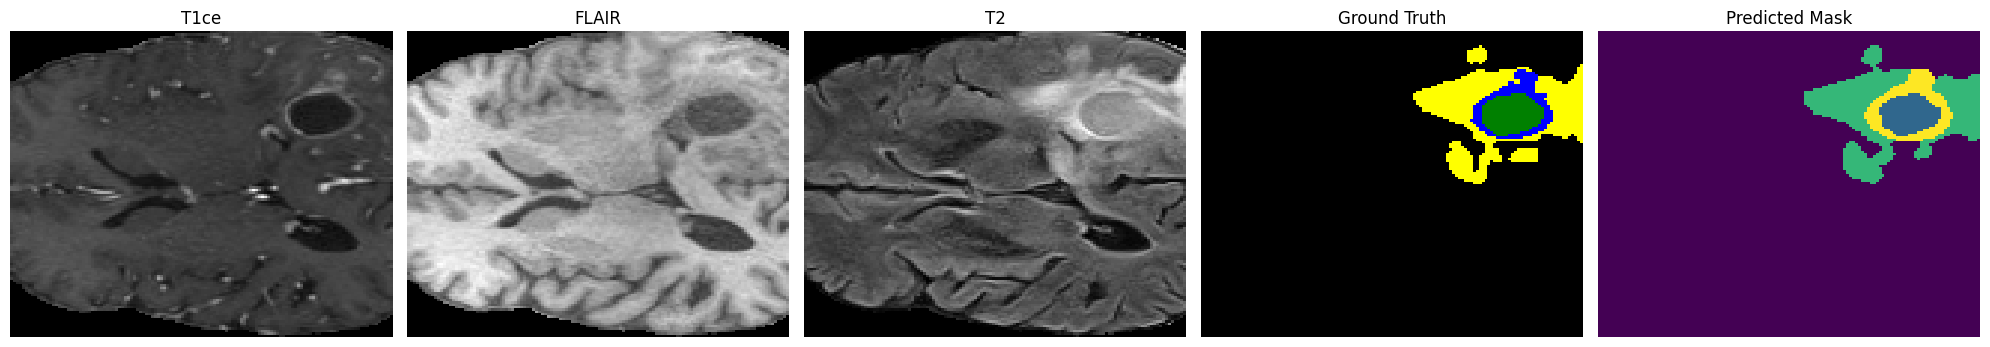

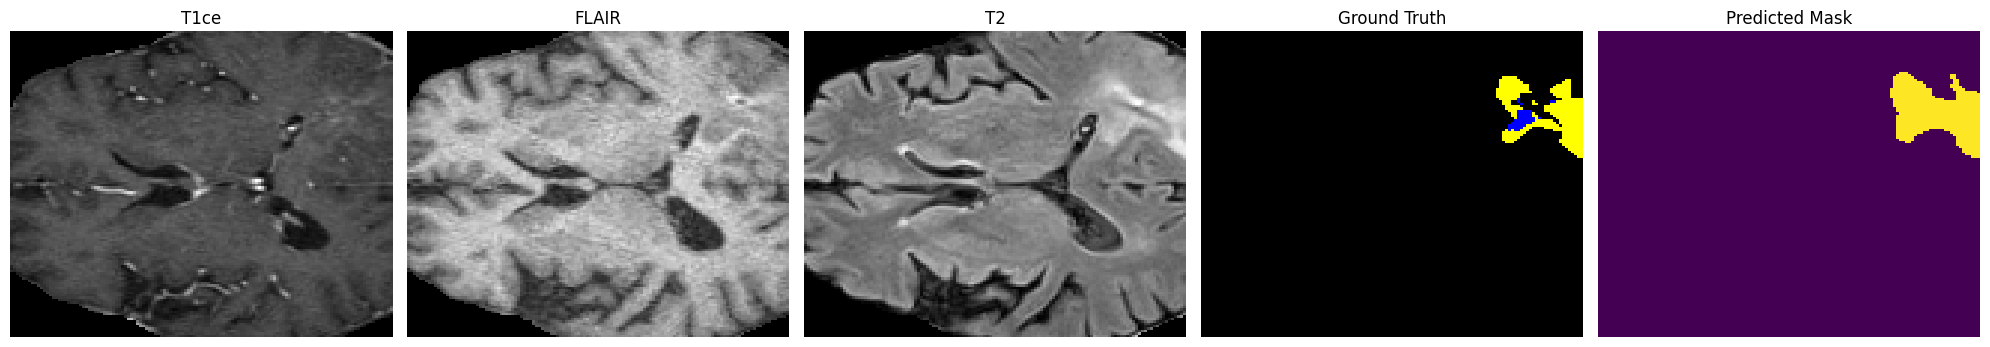

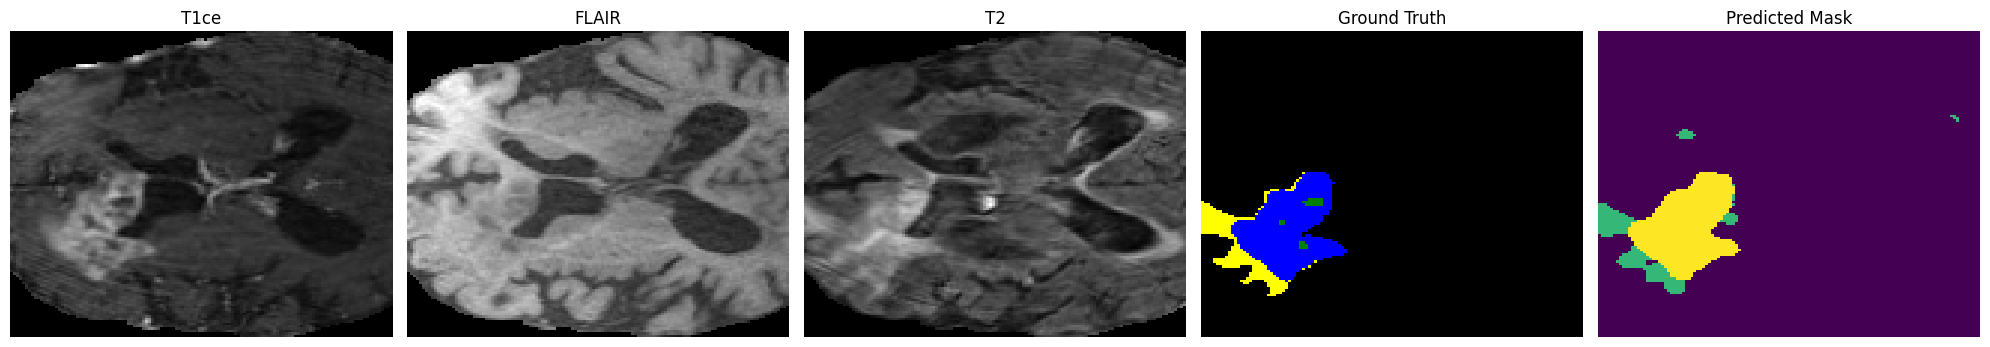

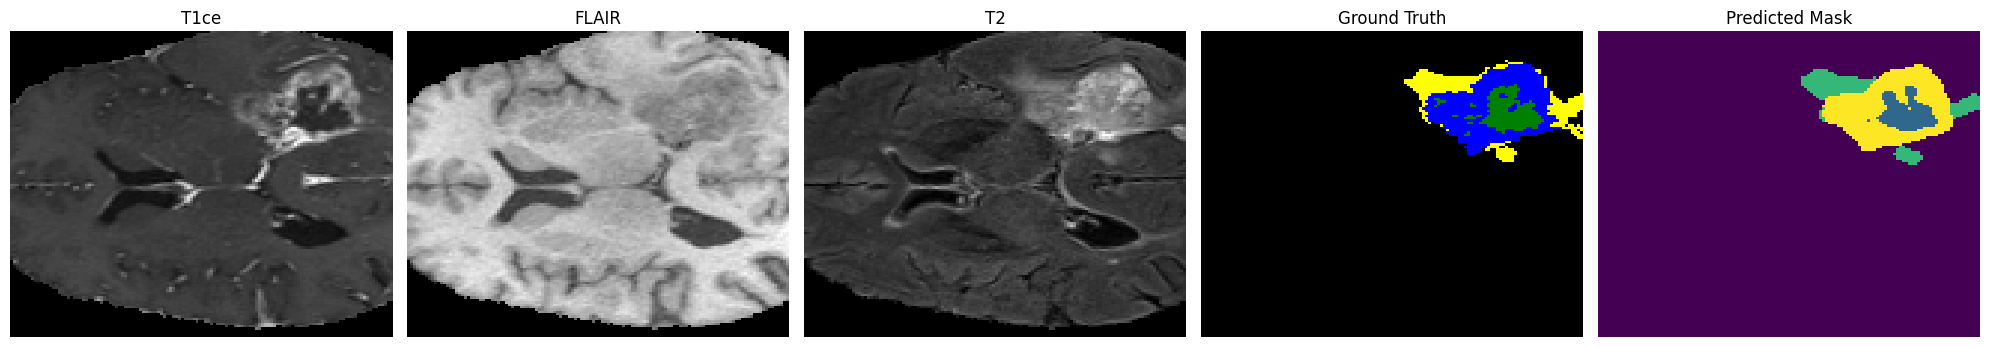

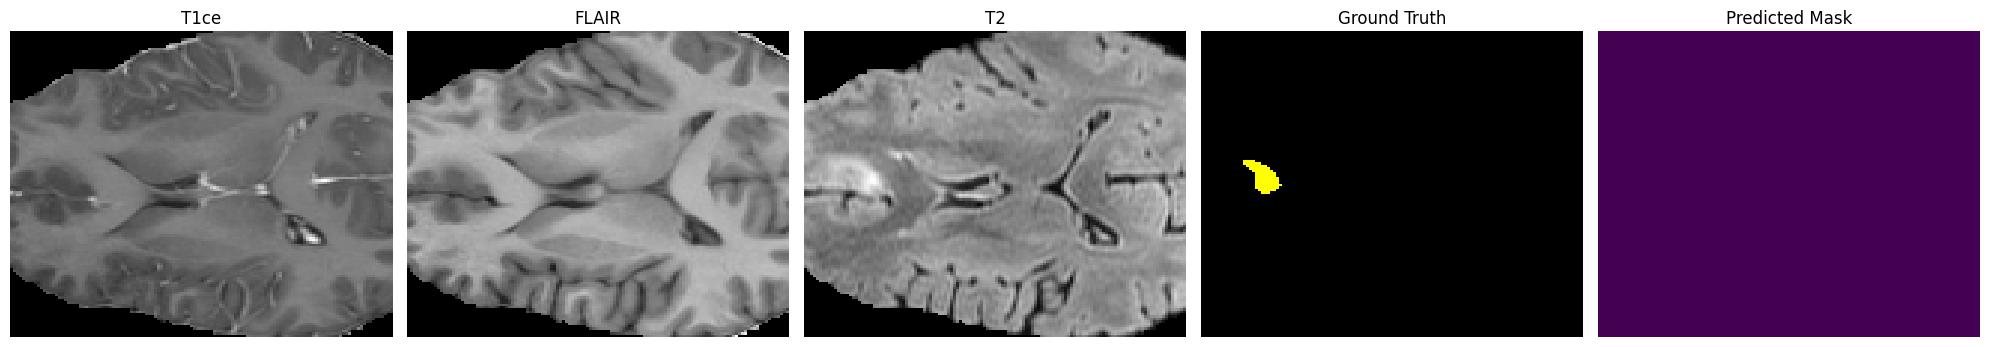

In [50]:
import os
import torch
import random
import matplotlib.pyplot as plt
from matplotlib import colors

# Path to your test set
test_path = "/content/drive/MyDrive/DL 3D Resnet Findings/dl_data_final/test"

# List patient folders
test_patients = sorted([
    f for f in os.listdir(test_path)
    if not f.startswith('.') and os.path.isdir(os.path.join(test_path, f))
])

# Load dataset
test_dataset = BraTSDataset(test_path, test_patients)

# Define colormap
cmap = colors.ListedColormap(["black", "green", "yellow", "blue"])
bounds = [0, 1, 2, 3, 4]
norm = colors.BoundaryNorm(bounds, cmap.N)

@torch.inference_mode()
def visualize_random_test_samples(model, dataset, device="cuda", num_samples=5):
    model.eval()
    for _ in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)
        X, y = dataset[idx]  # X: [C, D, H, W]
        X = X.unsqueeze(0).to(device).float()
        y_np = y.numpy()

        # Predict
        with torch.autocast(device_type=device):
            output = model(X)
        pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()

        # Use sagittal slice
        mid_slice = 64

        fig, ax = plt.subplots(1, 5, figsize=(20, 6))

        # Modalities: T1ce (0), FLAIR (1), T2 (2)
        ax[0].imshow(X[0, 0, :, :, mid_slice].cpu(), cmap="gray", interpolation="none", aspect=0.8)
        ax[0].set_title("T1ce")

        ax[1].imshow(X[0, 1, :, :, mid_slice].cpu(), cmap="gray", interpolation="none", aspect=0.8)
        ax[1].set_title("FLAIR")

        ax[2].imshow(X[0, 2, :, :, mid_slice].cpu(), cmap="gray", interpolation="none", aspect=0.8)
        ax[2].set_title("T2")

        # Ground Truth and Prediction
        ax[3].imshow(y_np[:, :, mid_slice], cmap=cmap, norm=norm, interpolation="none", aspect=0.8)
        ax[3].set_title("Ground Truth")

        ax[4].imshow(pred[:, :, mid_slice], cmap="viridis", interpolation="none", aspect=0.8)
        ax[4].set_title("Predicted Mask")

        for a in ax:
            a.axis("off")

        plt.tight_layout()
        plt.show()

# Run visualization
visualize_random_test_samples(model, test_dataset, device="cuda", num_samples=5)


### Code for saving test visualization on drive


In [39]:
import os
import torch
import matplotlib.pyplot as plt
from matplotlib import colors
from tqdm import tqdm

# Define output directory
save_dir = "/content/drive/MyDrive/CSCI566/3D Resnet/Test Visualizations"
os.makedirs(save_dir, exist_ok=True)

@torch.inference_mode()
def save_test_sample_visualizations(model, dataset, device="cuda"):
    model.eval()

    # Class color map: background, green, yellow, blue
    cmap = colors.ListedColormap(["black", "green", "yellow", "blue"])
    bounds = [0, 1, 2, 3, 4]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    for idx in tqdm(range(len(dataset)), desc="Saving test sample visualizations"):
        X, y = dataset[idx]  # X: [C, D, H, W], y: [D, H, W]
        X_input = X.unsqueeze(0).to(device).float()
        y_np = y.numpy()

        with torch.autocast(device_type=device):
            output = model(X_input)
            pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()

        # Axial mid-slice
        #mid_slice = y_np.shape[1] // 2
        mid_slice = 64

        fig, axs = plt.subplots(1, 5, figsize=(20, 6))

        # T1ce (index 2)
        axs[0].imshow(X[2, :, mid_slice, :], cmap="gray", interpolation="none")
        axs[0].set_title("T1ce")

        # FLAIR (index 0)
        axs[1].imshow(X[0, :, mid_slice, :], cmap="gray", interpolation="none")
        axs[1].set_title("FLAIR")

        # T2 (index 3)
        axs[2].imshow(X[3, :, mid_slice, :], cmap="gray", interpolation="none")
        axs[2].set_title("T2")

        # Ground Truth
        axs[3].imshow(y_np[:, mid_slice, :], cmap=cmap, norm=norm, interpolation="none")
        axs[3].set_title("Ground Truth")

        # Predicted Mask
        axs[4].imshow(pred[:, mid_slice, :], cmap=cmap, norm=norm, interpolation="none")
        axs[4].set_title("Predicted Mask")

        for ax in axs:
            ax.axis("off")

        plt.tight_layout()
        save_path = os.path.join(save_dir, f"test_sample_{idx:03d}.png")
        plt.savefig(save_path, dpi=150)
        plt.close()


In [40]:
save_test_sample_visualizations(model, test_dataset, device="cuda")


Saving test sample visualizations: 100%|██████████| 241/241 [21:01<00:00,  5.23s/it]


### Saving 2 particular patients outputs on the drive for final results

In [52]:
import os
import torch
import matplotlib.pyplot as plt
from matplotlib import colors

# Final save path
save_dir = "/content/drive/MyDrive/CSCI566/3D Resnet/final test patient output"
os.makedirs(save_dir, exist_ok=True)

# Patient IDs
patient_ids = ["BraTS-GLI-00401-000", "BraTS-GLI-00402-000"]
test_dataset = BraTSDataset("/content/drive/MyDrive/DL 3D Resnet Findings/dl_data_final/test", patient_ids)

# Define colormap
cmap = colors.ListedColormap(["black", "green", "yellow", "blue"])
bounds = [0, 1, 2, 3, 4]
norm = colors.BoundaryNorm(bounds, cmap.N)

@torch.inference_mode()
def save_specific_patient_outputs(model, dataset, device="cuda"):
    model.eval()
    for i in range(len(dataset)):
        X, y = dataset[i]  # X: [C, D, H, W]
        X_input = X.unsqueeze(0).to(device).float()
        y_np = y.numpy()

        # Predict
        with torch.autocast(device_type=device):
            output = model(X_input)
        pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()

        # Use sagittal view slice
        mid_slice = 64

        fig, ax = plt.subplots(1, 5, figsize=(20, 6))
        ax[0].imshow(X[0, :, :, mid_slice], cmap="gray", interpolation="none", aspect=0.8)
        ax[0].set_title("T1ce")

        ax[1].imshow(X[1, :, :, mid_slice], cmap="gray", interpolation="none", aspect=0.8)
        ax[1].set_title("FLAIR")

        ax[2].imshow(X[2, :, :, mid_slice], cmap="gray", interpolation="none", aspect=0.8)
        ax[2].set_title("T2")

        ax[3].imshow(y_np[:, :, mid_slice], cmap=cmap, norm=norm, interpolation="none", aspect=0.8)
        ax[3].set_title("Ground Truth")

        ax[4].imshow(pred[:, :, mid_slice], cmap="viridis", interpolation="none", aspect=0.8)
        ax[4].set_title("Predicted Mask")

        for a in ax:
            a.axis("off")

        plt.tight_layout()
        save_path = os.path.join(save_dir, f"{patient_ids[i]}.png")
        plt.savefig(save_path, dpi=150)
        plt.close()

# Run and save
save_specific_patient_outputs(model, test_dataset, device="cuda")
